<a href="https://colab.research.google.com/github/xcyzp/DetectorYolov8/blob/main/PV_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalacja YOLOv8
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
# Import potrzebnych bibliotek
import os
import shutil
import random
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2  # OpenCV do wczytywania i wyświetlania obrazów
import yaml # Do stworzenia pliku konfiguracyjnego

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# --- KONFIGURACJA ŚCIEŻEK
BASE_PATH = "/content/drive/MyDrive/PVDataSet"

# *** NOWA ZMIENNA: Główna ścieżka wyjściowa na Dysku Google ***
DRIVE_OUTPUT_PATH = "/content/drive/MyDrive/PV_YOLO_Output"
# Tworzymy ten folder, jeśli nie istnieje
os.makedirs(DRIVE_OUTPUT_PATH, exist_ok=True)
print(f"Dane wyjściowe będą zapisywane w: {DRIVE_OUTPUT_PATH}")

# Ścieżki do Twoich oryginalnych danych
image_dir = os.path.join(BASE_PATH, "images")

# Ścieżki do Twoich oryginalnych danych
image_dir = os.path.join(BASE_PATH, "images")
label_dir = os.path.join(BASE_PATH, "labels")
classes_file = os.path.join(BASE_PATH, "classes.txt")

# Ścieżka do stworzenia nowego, podzielonego datasetu (teraz na Dysku Google)
dataset_root = Path(DRIVE_OUTPUT_PATH) / "pv_dataset"
dataset_root.mkdir(parents=True, exist_ok=True)

# Definiujemy ścieżki dla YOLO
train_img_path = dataset_root / "images" / "train"
train_lbl_path = dataset_root / "labels" / "train"
val_img_path = dataset_root / "images" / "val"
val_lbl_path = dataset_root / "labels" / "val"

# Tworzymy foldery
train_img_path.mkdir(parents=True, exist_ok=True)
train_lbl_path.mkdir(parents=True, exist_ok=True)
val_img_path.mkdir(parents=True, exist_ok=True)
val_lbl_path.mkdir(parents=True, exist_ok=True)

# --- SKRYPT DZIELĄCY DANE ---
print("Rozpoczynam podział danych...")

# Pobieramy listę wszystkich obrazów
all_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(all_images) # Mieszamy losowo

# Definiujemy podział (np. 80% trening, 20% walidacja)
split_ratio = 0.8
split_index = int(len(all_images) * split_ratio)

train_images = all_images[:split_index]
val_images = all_images[split_index:]

# Funkcja pomocnicza do kopiowania plików
def copy_files(file_list, img_source, lbl_source, img_dest, lbl_dest):
    copied_labels = 0
    for img_name in file_list:
        # Kopiuj obraz
        shutil.copy(os.path.join(img_source, img_name), os.path.join(img_dest, img_name))

        # Sprawdź, czy istnieje etykieta i skopiuj ją
        label_name = Path(img_name).stem + ".txt"
        label_source_path = os.path.join(lbl_source, label_name)

        if os.path.exists(label_source_path):
            shutil.copy(label_source_path, os.path.join(lbl_dest, label_name))
            copied_labels += 1

# Kopiujemy pliki treningowe
copy_files(train_images, image_dir, label_dir, train_img_path, train_lbl_path)
# Kopiujemy pliki walidacyjne
copy_files(val_images, image_dir, label_dir, val_img_path, val_lbl_path)

print(f"Podział zakończony.")
print(f"Dane treningowe: {len(train_images)} obrazów.")
print(f"Dane walidacyjne: {len(val_images)} obrazów.")

# --- TWORZENIE PLIKU data.yaml ---
# Wczytujemy nazwy klas z pliku classes.txt
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f if line.strip()]

num_classes = len(classes)

# Tworzymy słownik konfiguracyjny
data_yaml = {
    'train': str(train_img_path),
    'val': str(val_img_path),
    'nc': num_classes,
    'names': classes
}

# Zapisujemy plik data.yaml
yaml_path = dataset_root / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"\nStworzono plik konfiguracyjny '{yaml_path}'")
print(f"Znalezione klasy: {classes}")

Mounted at /content/drive
Dane wyjściowe będą zapisywane w: /content/drive/MyDrive/PV_YOLO_Output
Rozpoczynam podział danych...
Podział zakończony.
Dane treningowe: 680 obrazów.
Dane walidacyjne: 171 obrazów.

Stworzono plik konfiguracyjny '/content/drive/MyDrive/PV_YOLO_Output/pv_dataset/data.yaml'
Znalezione klasy: ['crack', 'corrosion']


In [ ]:
# Ładujemy wstępnie wytrenowany model YOLOv8 (np. 'n' - nano, najmniejszy i najszybszy)
# Możesz też użyć 'yolov8s.pt', 'yolov8m.pt' dla większej dokładności kosztem prędkości.
model = YOLO('yolov8s.pt')

# Rozpoczynamy trening
# epochs: liczba epok (zalecane 50-100+ dla dobrych wyników, 25 dla szybkiego testu)
# imgsz: rozmiar obrazu (Twoje przykłady mają 250, 320 to dobry kompromis)
# project: nazwa folderu na wyniki
# name: nazwa konkretnego przebiegu treningu
print("Rozpoczynam trening modelu...")
results = model.train(
    data=str(yaml_path),
    epochs=100,  # Zwiększ tę wartość (np. do 50 lub 100) dla lepszych wyników
    imgsz=640,
    project=os.path.join(DRIVE_OUTPUT_PATH, 'pv_defect_detector'), # <-- Zmieniona linia
    name='run2',
    exist_ok=True # Pozwala nadpisać poprzedni przebieg o tej samej nazwie
)

print("Trening zakończony.")
# Najważniejsze informacje (jak mAP, loss) są wyświetlane na żywo podczas treningu.

Rozpoczynam trening modelu...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PV_YOLO_Output/pv_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

In [ ]:
# Ścieżka do najlepszego zapisanego modelu
best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'

# Ładujemy najlepszy model
model = YOLO(best_model_path)

# Uruchamiamy walidację na zbiorze walidacyjnym
print("Uruchamiam walidację na najlepszym modelu...")
metrics = model.val()

# 'metrics' zawiera szczegółowe dane, np.:
print("\n--- Najlepsze Metryki ---")
print(f"mAP50-95 (Box): {metrics.box.map * 100:.2f}%") # Główna metryka
print(f"mAP50 (Box):    {metrics.box.map50 * 100:.2f}%")
print(f"Precision (Box):  {metrics.box.p[0] * 100:.2f}%") # Precyzja dla pierwszej klasy
print(f"Recall (Box):     {metrics.box.r[0] * 100:.2f}%") # Czułość dla pierwszej klasy

# Wyświetlanie obrazów z wynikami walidacji (np. macierz konfuzji)
# Pliki są zapisywane w folderze results.save_dir
print(f"\nSzczegółowe wyniki walidacji (np. macierz konfuzji) są zapisane w: {results.save_dir}")

Uruchamiam walidację na najlepszym modelu...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 1.0±1.1 ms, read: 3.3±1.4 MB/s, size: 6.9 KB)
val: Scanning /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/labels/val.cache... 84 images, 224 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 308/308 103.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 3.4it/s 6.0s
                   all        308        261      0.877      0.845      0.918      0.657
                 crack         16         16      0.799      0.812      0.869      0.654
             corrosion         71        245      0.956      0.877      0.967      0.659
Speed: 3.2ms preprocess, 9.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/runs/detect/val

--- Najlepsze Metryki ---
mAP

Uruchamiam predykcję na 50 losowych obrazach ze zbioru walidacyjnego...

--- Predykcja 1/50 (Obraz: A10-DH3000-1500h-PT-cell8.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1500h-PT-cell8.jpg: 640x640 (no detections), 16.3ms
Speed: 2.7ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 1...


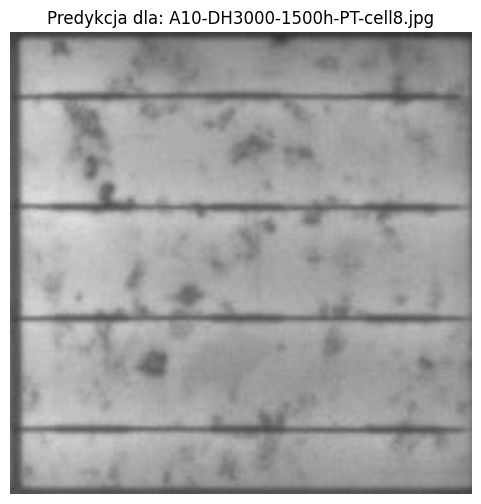


--- Predykcja 2/50 (Obraz: A11-DH3000-2000h-PT-cell17.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-2000h-PT-cell17.jpg: 640x640 (no detections), 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 2...


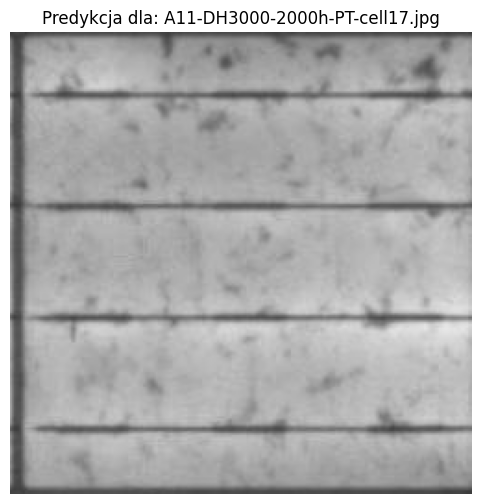


--- Predykcja 3/50 (Obraz: A1-DH3000-1000h-PT-cell18.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1000h-PT-cell18.jpg: 640x640 (no detections), 16.4ms
Speed: 4.9ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 3...


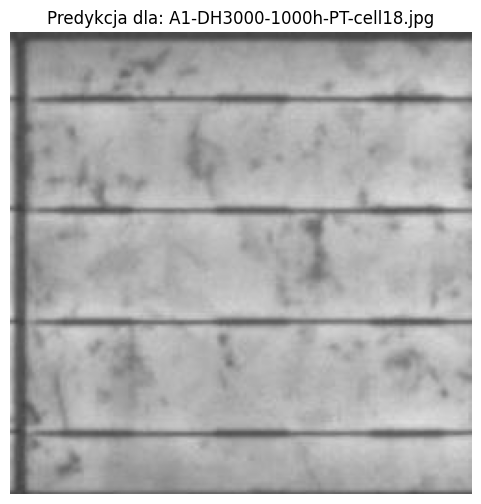


--- Predykcja 4/50 (Obraz: A11-DH3000-2000h-PT-cell54.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-2000h-PT-cell54.jpg: 640x640 (no detections), 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 4...


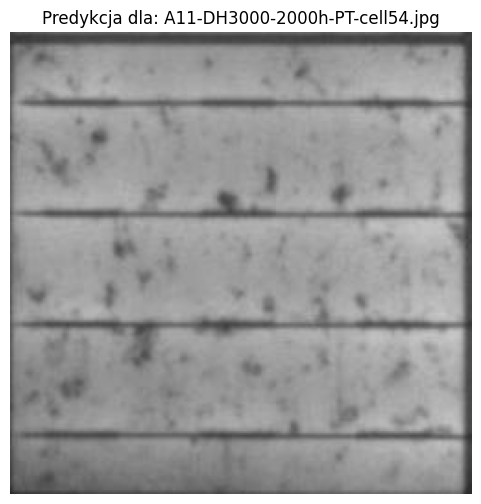


--- Predykcja 5/50 (Obraz: A1-DH3000-2000h-PT-cell47.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-2000h-PT-cell47.jpg: 640x640 (no detections), 16.3ms
Speed: 2.8ms preprocess, 16.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 5...


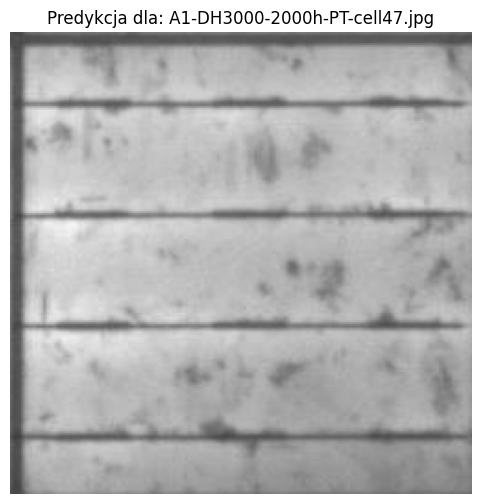


--- Predykcja 6/50 (Obraz: A10-DH3000-500h-PT-cell37.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell37.jpg: 640x640 (no detections), 16.3ms
Speed: 3.8ms preprocess, 16.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 6...


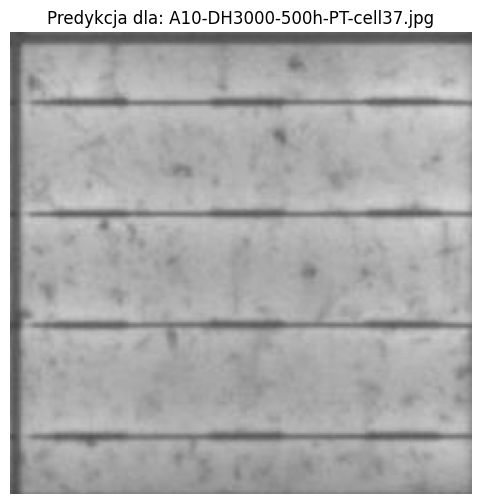


--- Predykcja 7/50 (Obraz: A10-DH3000-3000h-PT-cell23.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-3000h-PT-cell23.jpg: 640x640 4 corrosions, 16.4ms
Speed: 3.7ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 77.07%)
  -> Wykryto: corrosion (Pewność: 75.99%)
  -> Wykryto: corrosion (Pewność: 72.93%)
  -> Wykryto: corrosion (Pewność: 72.85%)
Wyświetlam przykładowy obraz 7...


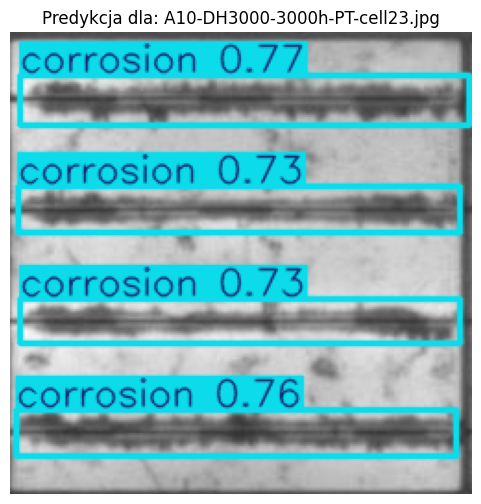


--- Predykcja 8/50 (Obraz: A10-DH3000-2000h-PT-cell55.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-2000h-PT-cell55.jpg: 640x640 1 corrosion, 16.3ms
Speed: 5.0ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 46.33%)
Wyświetlam przykładowy obraz 8...


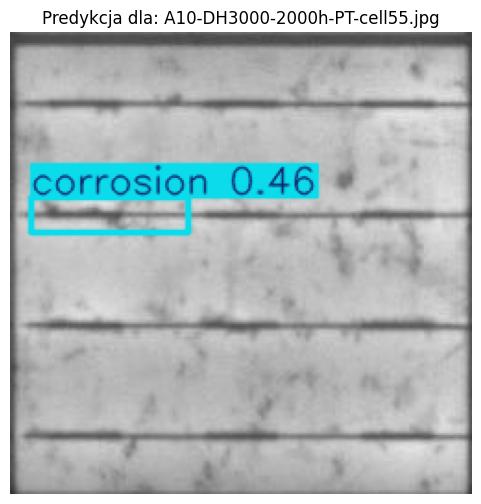


--- Predykcja 9/50 (Obraz: A11-DH3000-1500h-PT-cell9.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1500h-PT-cell9.jpg: 640x640 (no detections), 16.4ms
Speed: 3.7ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 9...


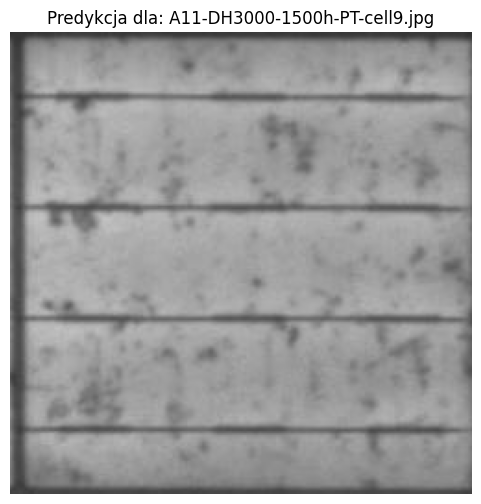


--- Predykcja 10/50 (Obraz: A1-DH3000-2000h-PT-cell9.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-2000h-PT-cell9.jpg: 640x640 (no detections), 16.3ms
Speed: 4.3ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 10...


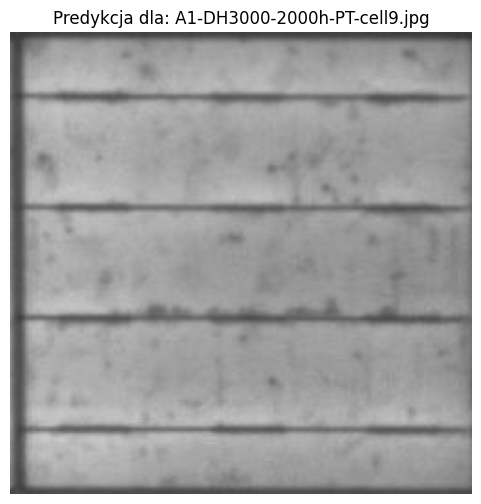


--- Predykcja 11/50 (Obraz: A1-DH3000-2000h-PT-cell46.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-2000h-PT-cell46.jpg: 640x640 (no detections), 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 11...


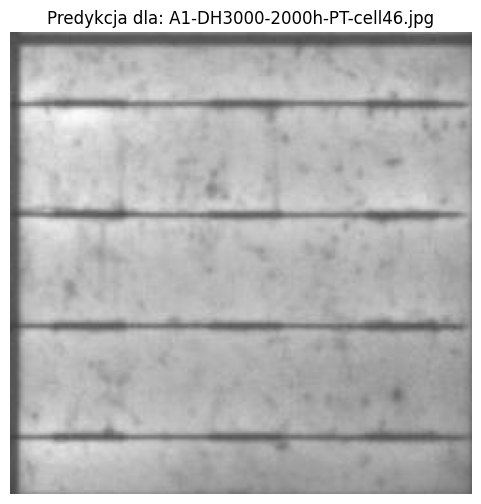


--- Predykcja 12/50 (Obraz: A1-DH3000-1000h-PT-cell4.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1000h-PT-cell4.jpg: 640x640 (no detections), 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 12...


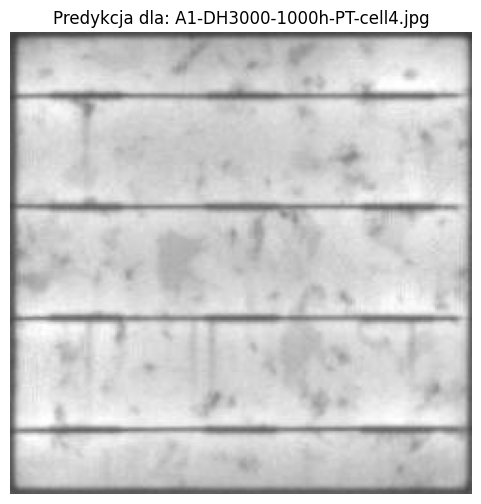


--- Predykcja 13/50 (Obraz: A1-DH3000-1000h-PT-cell48.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1000h-PT-cell48.jpg: 640x640 (no detections), 16.3ms
Speed: 4.8ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 13...


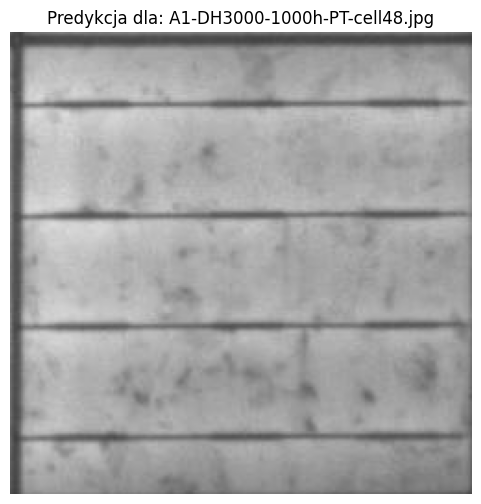


--- Predykcja 14/50 (Obraz: A10-DH3000-500h-PT-cell55.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell55.jpg: 640x640 (no detections), 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 14...


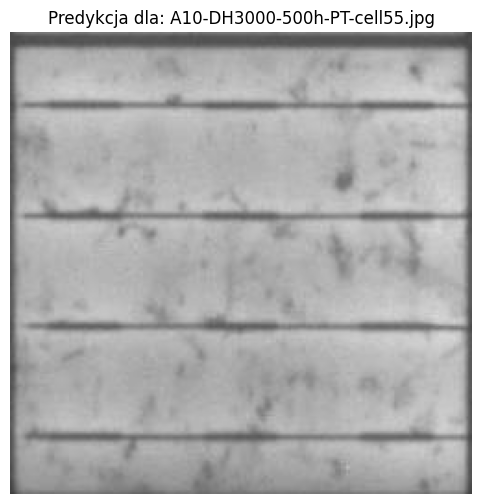


--- Predykcja 15/50 (Obraz: A11-DH3000-2000h-PT-cell58.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-2000h-PT-cell58.jpg: 640x640 (no detections), 16.5ms
Speed: 6.5ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 15...


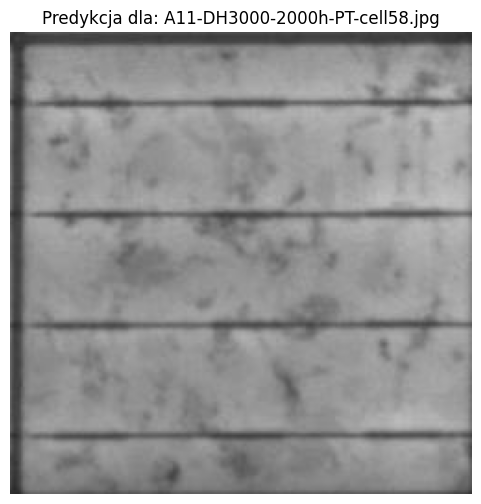


--- Predykcja 16/50 (Obraz: A10-DH3000-3000h-PT-cell18.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-3000h-PT-cell18.jpg: 640x640 4 corrosions, 16.3ms
Speed: 4.0ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 77.23%)
  -> Wykryto: corrosion (Pewność: 75.59%)
  -> Wykryto: corrosion (Pewność: 72.94%)
  -> Wykryto: corrosion (Pewność: 72.92%)
Wyświetlam przykładowy obraz 16...


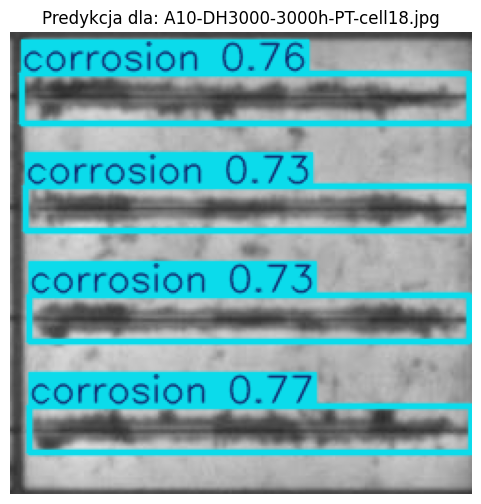


--- Predykcja 17/50 (Obraz: A1-DH3000-1000h-PT-cell20.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1000h-PT-cell20.jpg: 640x640 (no detections), 16.3ms
Speed: 4.3ms preprocess, 16.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 17...


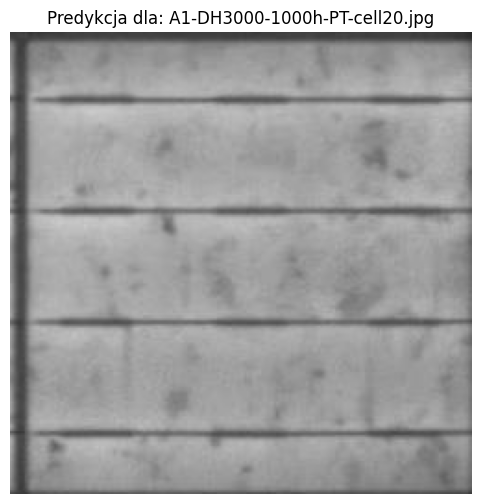


--- Predykcja 18/50 (Obraz: A11-DH3000-1500h-PT-cell35.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1500h-PT-cell35.jpg: 640x640 (no detections), 16.3ms
Speed: 4.2ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 18...


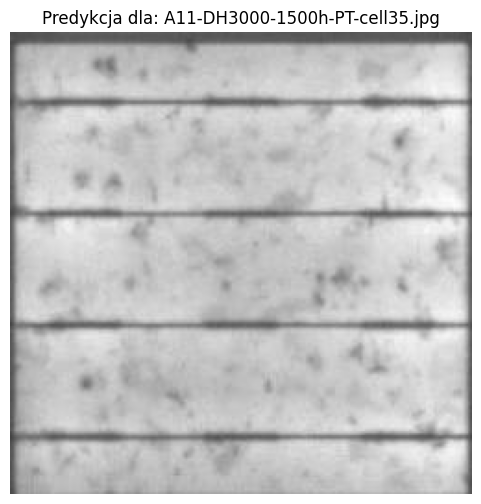


--- Predykcja 19/50 (Obraz: A11-DH3000-1500h-PT-cell60.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1500h-PT-cell60.jpg: 640x640 (no detections), 16.3ms
Speed: 4.8ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 19...


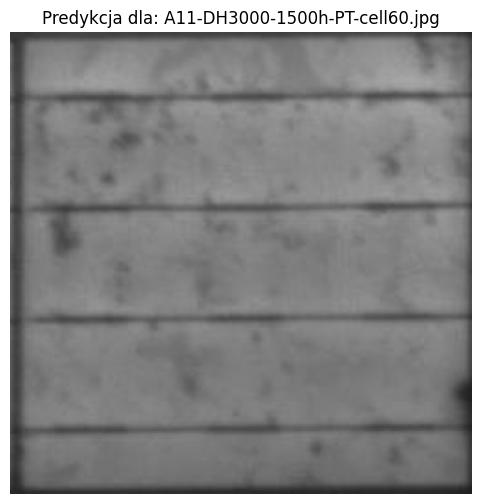


--- Predykcja 20/50 (Obraz: A1-DH3000-500h-PT-cell6.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-500h-PT-cell6.jpg: 640x640 (no detections), 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 20...


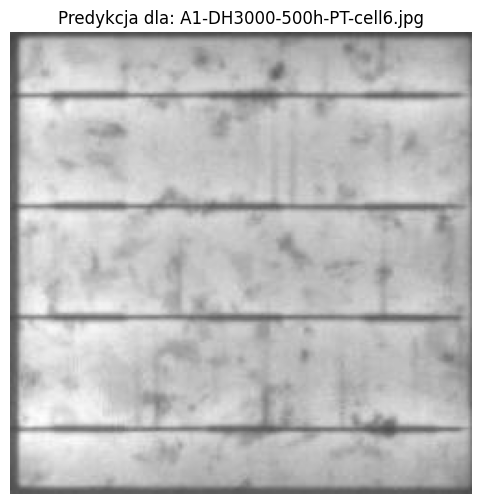


--- Predykcja 21/50 (Obraz: A10-DH3000-2000h-PT-cell38.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-2000h-PT-cell38.jpg: 640x640 7 corrosions, 18.4ms
Speed: 3.2ms preprocess, 18.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 56.20%)
  -> Wykryto: corrosion (Pewność: 52.43%)
  -> Wykryto: corrosion (Pewność: 49.54%)
  -> Wykryto: corrosion (Pewność: 49.50%)
  -> Wykryto: corrosion (Pewność: 42.10%)
  -> Wykryto: corrosion (Pewność: 31.14%)
  -> Wykryto: corrosion (Pewność: 30.41%)
Wyświetlam przykładowy obraz 21...


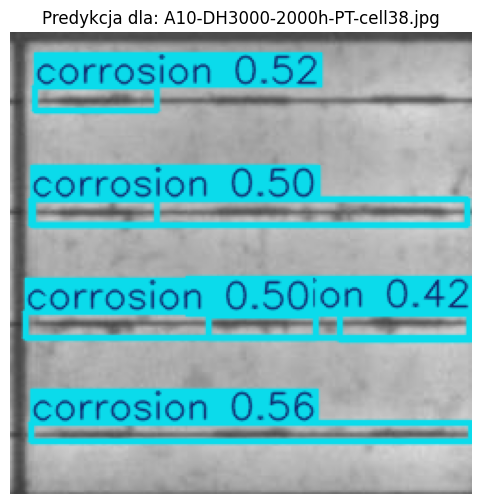


--- Predykcja 22/50 (Obraz: A1-DH3000-500h-PT-cell22.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-500h-PT-cell22.jpg: 640x640 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 22...


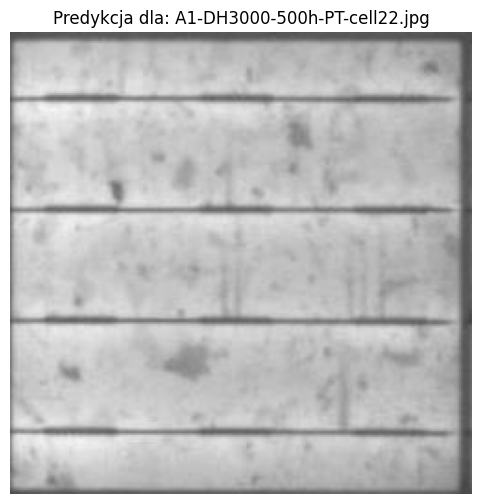


--- Predykcja 23/50 (Obraz: A10-DH3000-1500h-PT-cell56.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1500h-PT-cell56.jpg: 640x640 1 corrosion, 16.5ms
Speed: 4.3ms preprocess, 16.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 28.94%)
Wyświetlam przykładowy obraz 23...


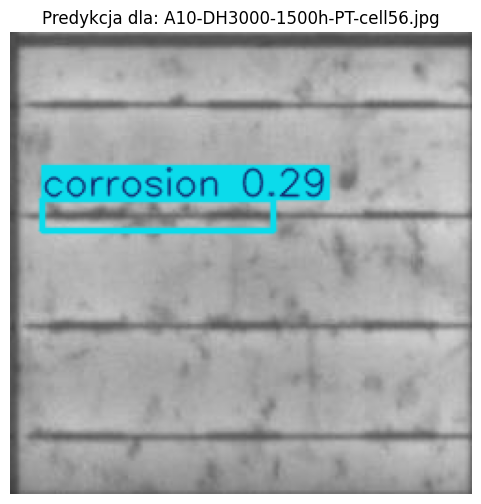


--- Predykcja 24/50 (Obraz: A1-DH3000-500h-PT-cell40.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-500h-PT-cell40.jpg: 640x640 (no detections), 16.4ms
Speed: 3.2ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 24...


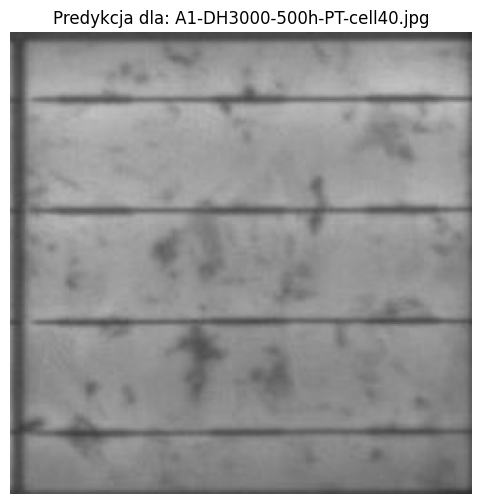


--- Predykcja 25/50 (Obraz: A10-DH3000-1000h-PT-cell38.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1000h-PT-cell38.jpg: 640x640 (no detections), 16.8ms
Speed: 4.0ms preprocess, 16.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 25...


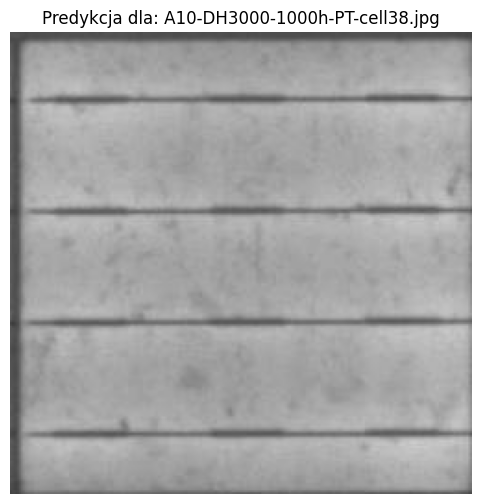


--- Predykcja 26/50 (Obraz: A11-DH3000-2000h-PT-cell25.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-2000h-PT-cell25.jpg: 640x640 (no detections), 16.4ms
Speed: 4.6ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 26...


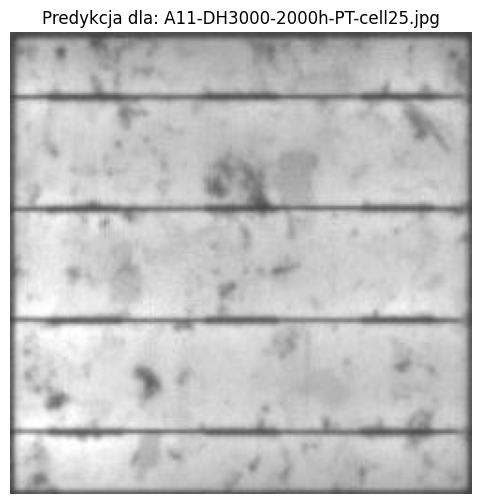


--- Predykcja 27/50 (Obraz: A10-DH3000-1500h-PT-cell24.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1500h-PT-cell24.jpg: 640x640 (no detections), 17.0ms
Speed: 4.7ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 27...


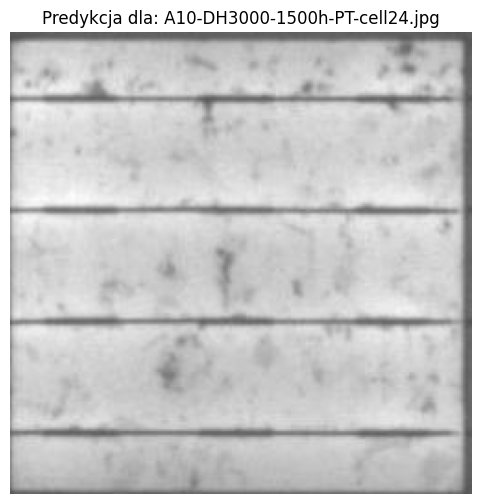


--- Predykcja 28/50 (Obraz: A11-DH3000-500h-PT-cell21.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-500h-PT-cell21.jpg: 640x640 (no detections), 16.3ms
Speed: 5.1ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 28...


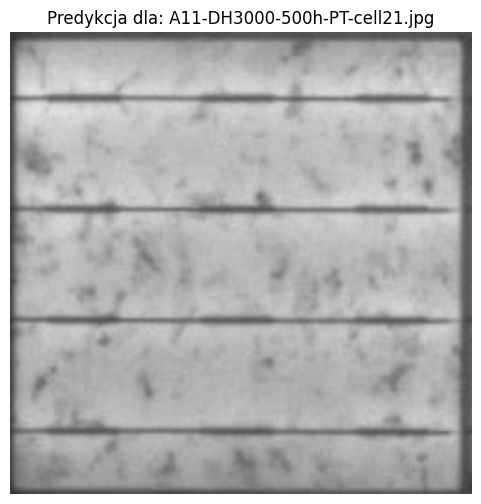


--- Predykcja 29/50 (Obraz: A10-DH3000-2000h-PT-cell6.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-2000h-PT-cell6.jpg: 640x640 (no detections), 16.3ms
Speed: 4.6ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 29...


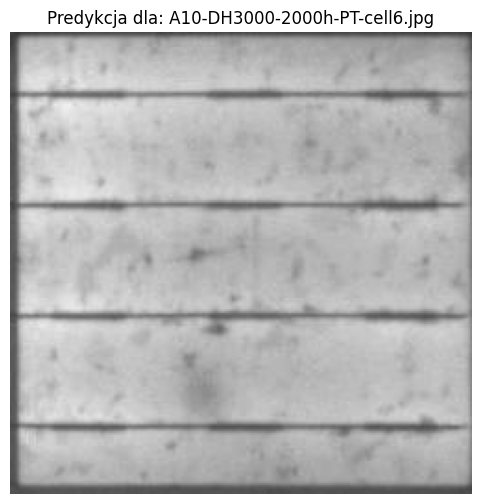


--- Predykcja 30/50 (Obraz: A11-DH3000-1500h-PT-cell27.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1500h-PT-cell27.jpg: 640x640 1 crack, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: crack (Pewność: 65.54%)
Wyświetlam przykładowy obraz 30...


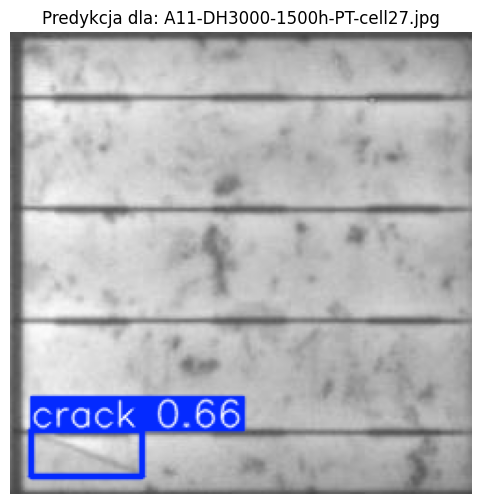


--- Predykcja 31/50 (Obraz: A1-DH3000-1500h-PT-cell3.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1500h-PT-cell3.jpg: 640x640 (no detections), 16.4ms
Speed: 4.4ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 31...


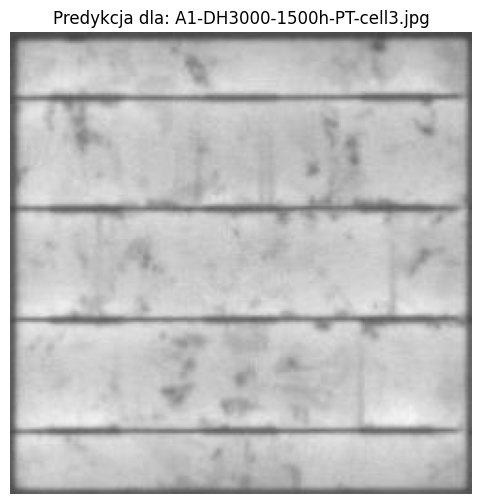


--- Predykcja 32/50 (Obraz: A11-DH3000-1000h-PT-cell42.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1000h-PT-cell42.jpg: 640x640 (no detections), 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 32...


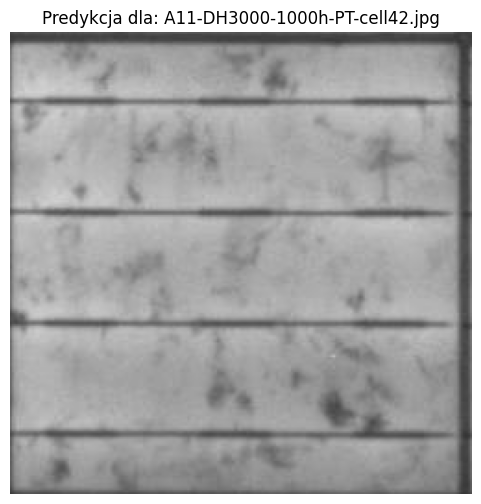


--- Predykcja 33/50 (Obraz: A10-DH3000-2000h-PT-cell18.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-2000h-PT-cell18.jpg: 640x640 2 corrosions, 16.4ms
Speed: 3.2ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 45.35%)
  -> Wykryto: corrosion (Pewność: 26.78%)
Wyświetlam przykładowy obraz 33...


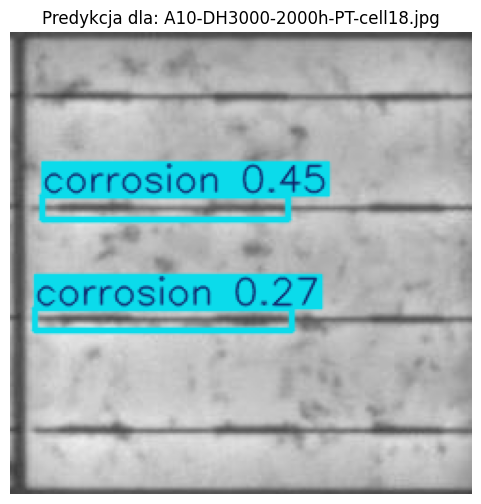


--- Predykcja 34/50 (Obraz: A10-DH3000-500h-PT-cell1.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell1.jpg: 640x640 (no detections), 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 34...


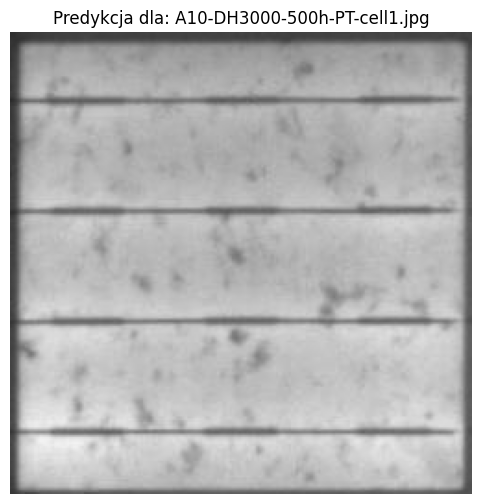


--- Predykcja 35/50 (Obraz: A11-DH3000-3000h-PT-cell38.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-3000h-PT-cell38.jpg: 640x640 4 corrosions, 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 76.12%)
  -> Wykryto: corrosion (Pewność: 75.94%)
  -> Wykryto: corrosion (Pewność: 74.06%)
  -> Wykryto: corrosion (Pewność: 72.84%)
Wyświetlam przykładowy obraz 35...


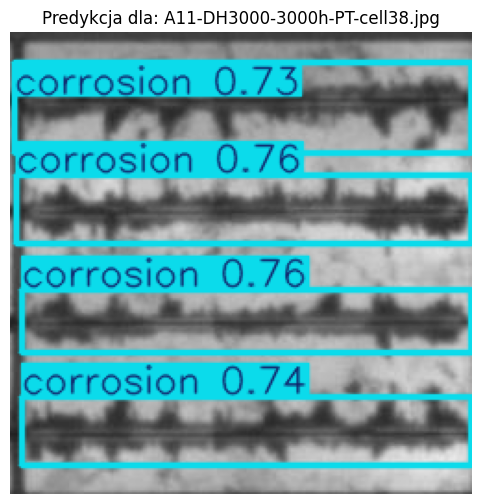


--- Predykcja 36/50 (Obraz: A1-DH3000-3000h-PT-cell57.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-3000h-PT-cell57.jpg: 640x640 4 corrosions, 16.3ms
Speed: 4.5ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 77.33%)
  -> Wykryto: corrosion (Pewność: 75.46%)
  -> Wykryto: corrosion (Pewność: 74.78%)
  -> Wykryto: corrosion (Pewność: 74.44%)
Wyświetlam przykładowy obraz 36...


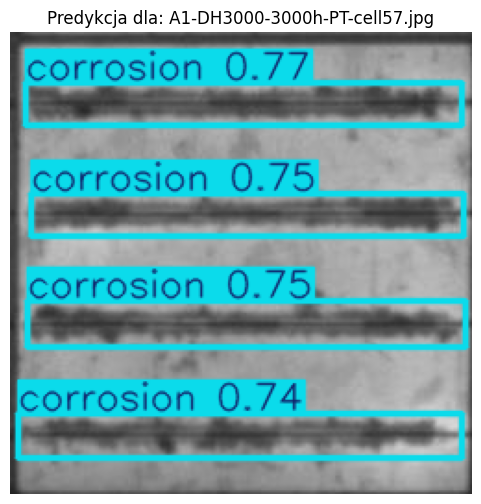


--- Predykcja 37/50 (Obraz: A1-DH3000-1000h-PT-cell42.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A1-DH3000-1000h-PT-cell42.jpg: 640x640 (no detections), 16.4ms
Speed: 5.1ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 37...


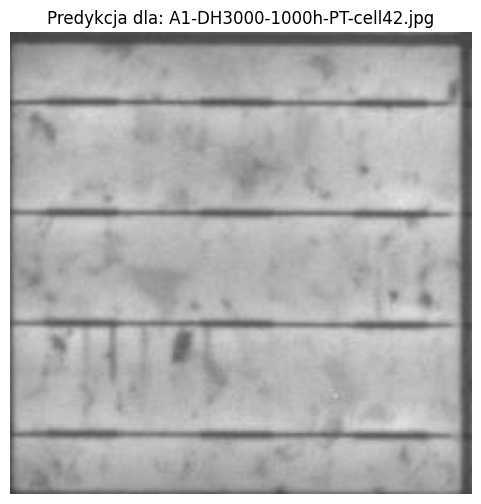


--- Predykcja 38/50 (Obraz: A10-DH3000-500h-PT-cell38.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell38.jpg: 640x640 (no detections), 16.3ms
Speed: 5.4ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 38...


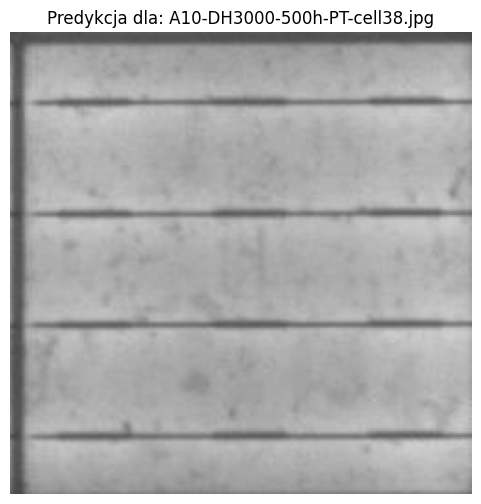


--- Predykcja 39/50 (Obraz: A10-DH3000-1000h-PT-cell45.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1000h-PT-cell45.jpg: 640x640 1 crack, 16.3ms
Speed: 5.5ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: crack (Pewność: 53.57%)
Wyświetlam przykładowy obraz 39...


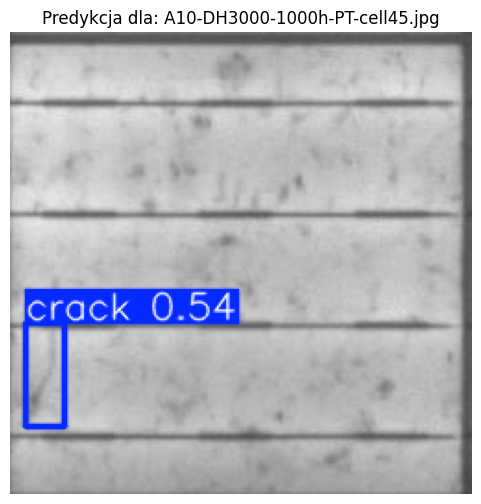


--- Predykcja 40/50 (Obraz: A11-DH3000-1500h-PT-cell7.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1500h-PT-cell7.jpg: 640x640 (no detections), 16.3ms
Speed: 4.8ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 40...


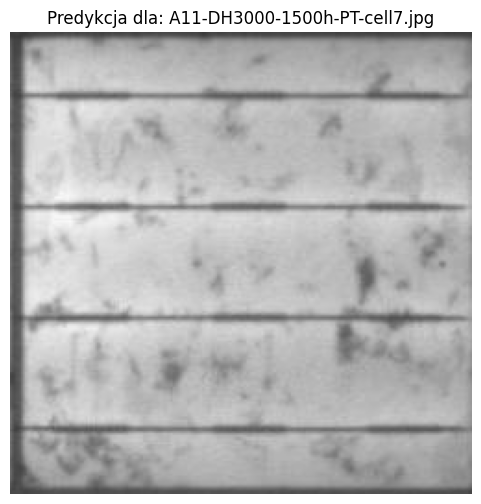


--- Predykcja 41/50 (Obraz: A11-DH3000-500h-PT-cell59.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-500h-PT-cell59.jpg: 640x640 (no detections), 16.4ms
Speed: 4.1ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 41...


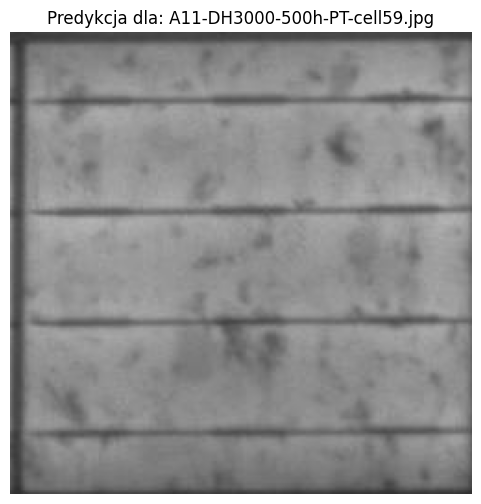


--- Predykcja 42/50 (Obraz: A10-DH3000-1500h-PT-cell28.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1500h-PT-cell28.jpg: 640x640 2 corrosions, 16.4ms
Speed: 6.1ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 42.24%)
  -> Wykryto: corrosion (Pewność: 36.84%)
Wyświetlam przykładowy obraz 42...


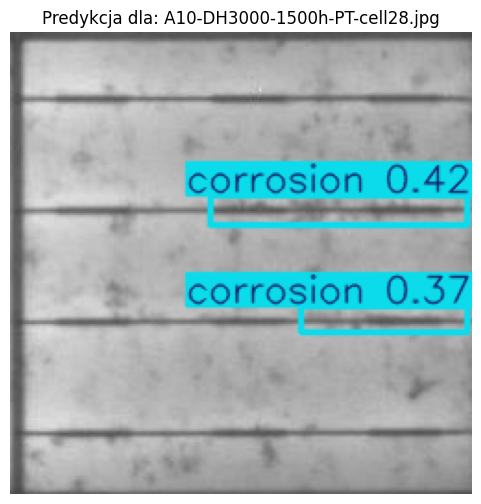


--- Predykcja 43/50 (Obraz: A10-DH3000-500h-PT-cell60.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell60.jpg: 640x640 1 crack, 18.0ms
Speed: 3.5ms preprocess, 18.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: crack (Pewność: 73.84%)
Wyświetlam przykładowy obraz 43...


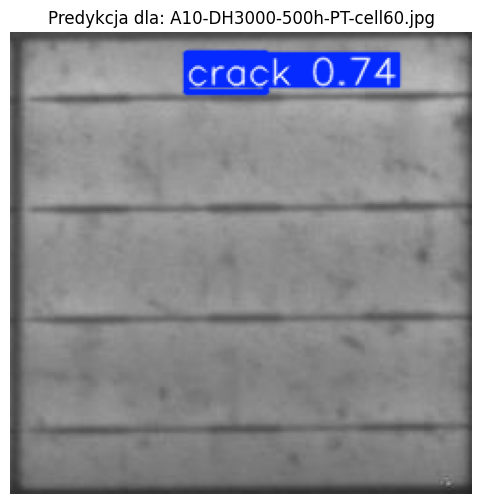


--- Predykcja 44/50 (Obraz: A11-DH3000-3000h-PT-cell51.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-3000h-PT-cell51.jpg: 640x640 4 corrosions, 18.3ms
Speed: 3.1ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: corrosion (Pewność: 73.59%)
  -> Wykryto: corrosion (Pewność: 71.03%)
  -> Wykryto: corrosion (Pewność: 69.42%)
  -> Wykryto: corrosion (Pewność: 68.89%)
Wyświetlam przykładowy obraz 44...


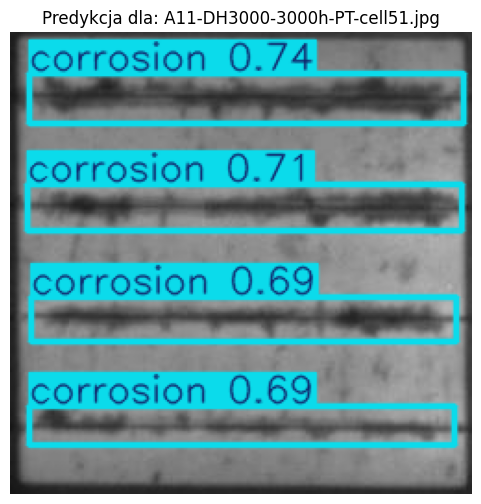


--- Predykcja 45/50 (Obraz: A11-DH3000-1000h-PT-cell34.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1000h-PT-cell34.jpg: 640x640 (no detections), 16.4ms
Speed: 6.3ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 45...


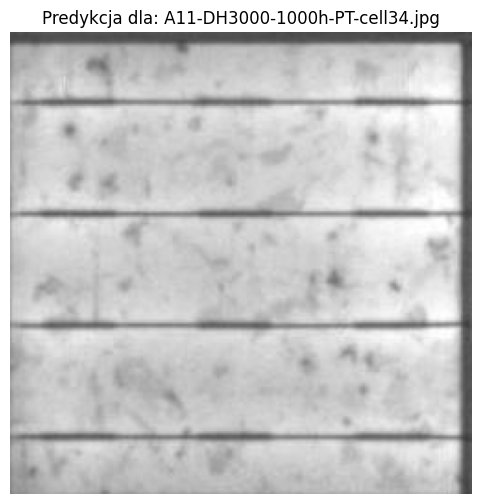


--- Predykcja 46/50 (Obraz: A10-DH3000-1000h-PT-cell34.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-1000h-PT-cell34.jpg: 640x640 (no detections), 16.3ms
Speed: 5.3ms preprocess, 16.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 46...


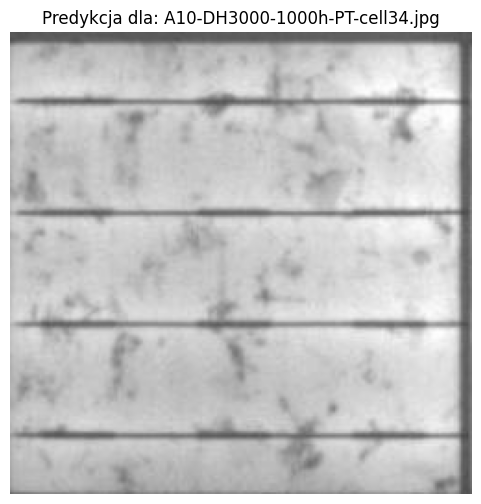


--- Predykcja 47/50 (Obraz: A10-DH3000-500h-PT-cell49.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A10-DH3000-500h-PT-cell49.jpg: 640x640 (no detections), 29.9ms
Speed: 5.3ms preprocess, 29.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 47...


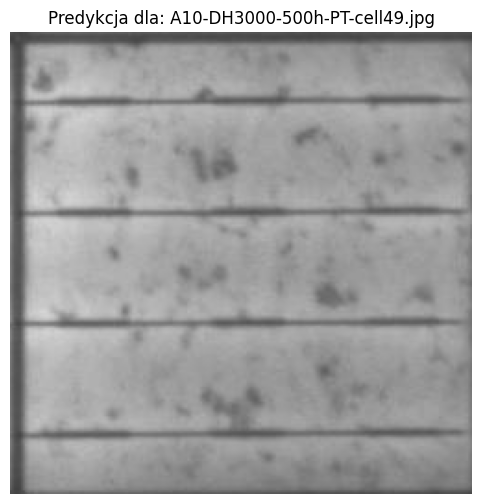


--- Predykcja 48/50 (Obraz: A11-DH3000-1000h-PT-cell15.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1000h-PT-cell15.jpg: 640x640 (no detections), 17.5ms
Speed: 4.2ms preprocess, 17.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 48...


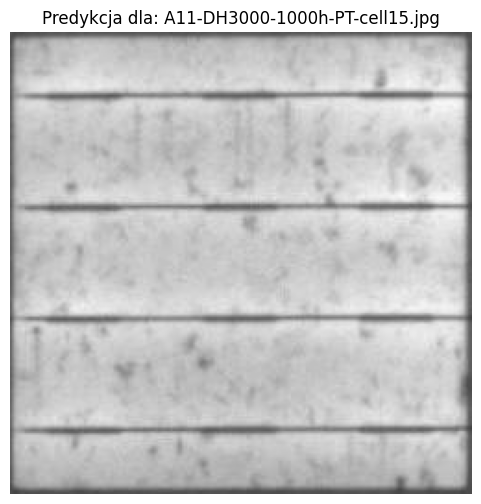


--- Predykcja 49/50 (Obraz: A11-DH3000-1000h-PT-cell60.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-1000h-PT-cell60.jpg: 640x640 (no detections), 16.6ms
Speed: 7.6ms preprocess, 16.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Nie wykryto żadnych defektów na tym obrazie.
Wyświetlam przykładowy obraz 49...


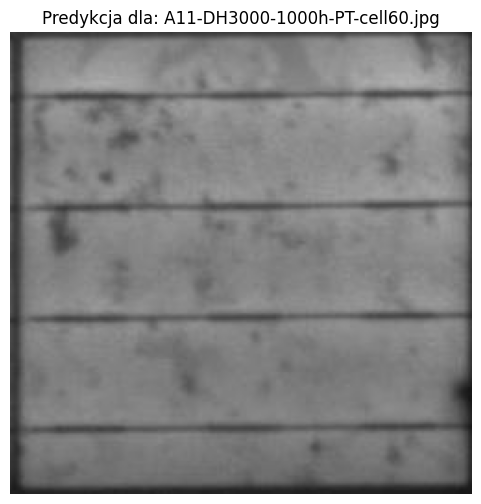


--- Predykcja 50/50 (Obraz: A11-DH3000-2000h-PT-cell27.jpg) ---

image 1/1 /content/drive/MyDrive/PV_YOLO_Output/pv_dataset/images/val/A11-DH3000-2000h-PT-cell27.jpg: 640x640 1 crack, 16.3ms
Speed: 5.8ms preprocess, 16.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
  -> Wykryto: crack (Pewność: 59.53%)
Wyświetlam przykładowy obraz 50...


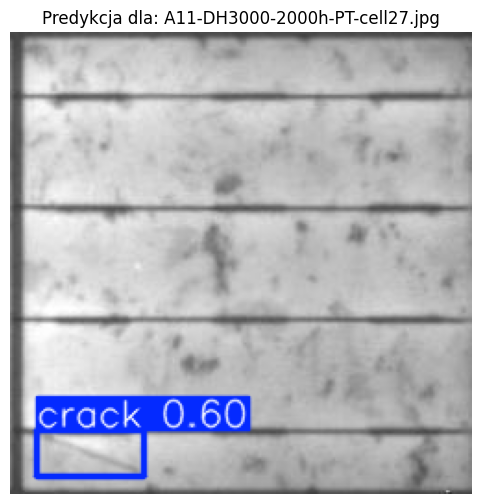

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Ścieżka do najlepszego modelu (z kroku 4)
# Upewnij się, że zmienna 'results' jest wciąż dostępna z kroku 3
# Jeśli nie jest, ustaw ścieżkę ręcznie, np:
# best_model_path = "/content/pv_defect_detector/run1/weights/best.pt"
best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
model = YOLO(best_model_path)

# Ścieżka do obrazów walidacyjnych (z kroku 2)
# Upewnij się, że zmienna 'val_img_path' jest dostępna
val_img_path = dataset_root / "images" / "val"


# --- Predykcja na 50 obrazach ---

# Pobieramy listę wszystkich obrazów walidacyjnych
all_val_images_list = list(val_img_path.glob("*.jpg")) + list(val_img_path.glob("*.png"))

# Określamy, na ilu obrazach zrobić predykcję (maksymalnie 50)
num_to_predict = min(50, len(all_val_images_list))

# Wybieramy losową próbkę
if num_to_predict > 0:
    sample_images_to_predict = random.sample(all_val_images_list, num_to_predict)
    print(f"Uruchamiam predykcję na {num_to_predict} losowych obrazach ze zbioru walidacyjnego...")

    # Ustawiamy, ile obrazów chcemy faktycznie narysować (żeby nie zalać notatnika)
    MAX_IMAGES_TO_PLOT = 50

    for i, image_path in enumerate(sample_images_to_predict):
        print(f"\n--- Predykcja {i+1}/{num_to_predict} (Obraz: {image_path.name}) ---")

        # Dokonujemy predykcji
        pred_results = model(image_path)
        result = pred_results[0] # Bierzemy pierwszy wynik

        # Wyświetlanie procentowej pewności (tekstowo)
        if len(result.boxes) == 0:
            print("Nie wykryto żadnych defektów na tym obrazie.")
        else:
            for box in result.boxes:
                class_id = int(box.cls[0])
                class_name = model.names[class_id]
                confidence = float(box.conf[0])
                print(f"  -> Wykryto: {class_name} (Pewność: {confidence * 100:.2f}%)")

        # Wyświetlamy tylko kilka pierwszych obrazów
        if i < MAX_IMAGES_TO_PLOT:
            print(f"Wyświetlam przykładowy obraz {i+1}...")
            img_with_boxes = result.plot()
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(6, 6))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"Predykcja dla: {image_path.name}")
            plt.show()

    if num_to_predict > MAX_IMAGES_TO_PLOT:
        print(f"\nWyświetlono {MAX_IMAGES_TO_PLOT} przykładowe obrazy. Wyniki tekstowe dla wszystkich {num_to_predict} zostały wypisane powyżej.")

else:
    print("Błąd: Nie znaleziono obrazów walidacyjnych w ścieżce:", val_img_path)